# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

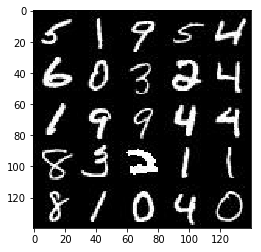

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

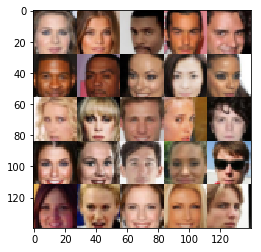

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 第一层，第一层不使用batch_normal
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        leak_relu1 = tf.maximum(conv1 * alpha, conv1)
        # 评审员建议：在每一层leak relu层后面添加一层dropout
        drop_out1 = tf.nn.dropout(leak_relu1, keep_prob=0.8)
        
        conv2 = tf.layers.conv2d(drop_out1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_normal2 = tf.layers.batch_normalization(conv2, training=True)
        leak_relu2 = tf.maximum(batch_normal2 * alpha, batch_normal2)
        drop_out2 = tf.nn.dropout(leak_relu2, keep_prob=0.8)
        
        conv3 = tf.layers.conv2d(drop_out2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_normal3 = tf.layers.batch_normalization(conv3, training=True)
        leak_relu3 = tf.maximum(batch_normal3 * alpha, batch_normal3)
        drop_out3 = tf.nn.dropout(leak_relu3, keep_prob=0.8)
        
        flatten = tf.contrib.layers.flatten(drop_out3)
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
    return output, logits
   




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 3 * 3 * 512)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # 此时，反卷积之后的输出为 4×4×512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 此时，反卷积之后的输出为 7×7×256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training =  is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 此时，反卷积之后的输出为 14×14×128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 此时，反卷积之后的输出为 28×28×3
        output = tf.tanh(logits)
       
     
        
        return output
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss

  

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars = tf.trainable_variables()
    g_vars = [var for var in all_vars if var.name.startswith('generator')]

    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    
    # 此处总是忘记加control_dependencies和beta
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], 
                                                 data_shape[2], 
                                                 data_shape[3], 
                                                 z_dim)
    d_loss, g_loss = model_loss(input_real, 
                                input_z, 
                                data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, 
                                         g_loss, 
                                         learning_rate, 
                                         beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # 前面提到数据的范围是[-0.5, 0.5],图像大小为28×28，为调整到[-1, 1]之间，所以乘以2
                batch_images = batch_images * 2
                
                #批量的z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict = {input_real:batch_images, 
                                                   input_z:batch_z,
                                                   lr:learning_rate})
                
                sess.run(g_train_opt, feed_dict = {input_real:batch_images, 
                                                   input_z:batch_z,
                                                   lr:learning_rate})
                if steps % 50 ==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 50... Discriminator Loss: 0.9723... Generator Loss: 1.2295
Epoch 1/2... Steps 100... Discriminator Loss: 1.3970... Generator Loss: 2.7132


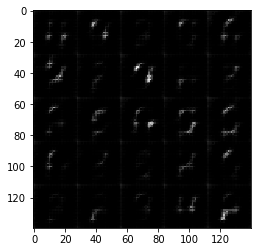

Epoch 1/2... Steps 150... Discriminator Loss: 1.3909... Generator Loss: 0.9691
Epoch 1/2... Steps 200... Discriminator Loss: 1.4755... Generator Loss: 2.0610


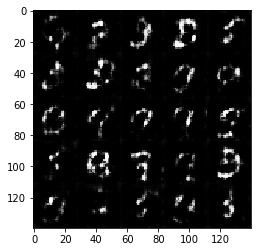

Epoch 1/2... Steps 250... Discriminator Loss: 1.1965... Generator Loss: 1.2797
Epoch 1/2... Steps 300... Discriminator Loss: 1.2298... Generator Loss: 1.4303


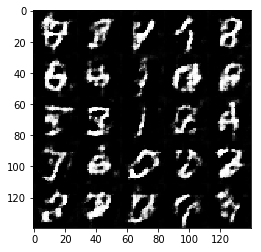

Epoch 1/2... Steps 350... Discriminator Loss: 1.2376... Generator Loss: 1.5563
Epoch 1/2... Steps 400... Discriminator Loss: 1.5363... Generator Loss: 0.4323


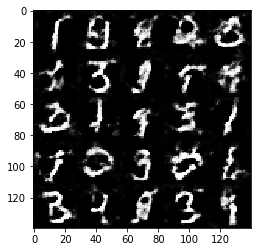

Epoch 1/2... Steps 450... Discriminator Loss: 1.1840... Generator Loss: 1.1258
Epoch 1/2... Steps 500... Discriminator Loss: 1.2261... Generator Loss: 1.2858


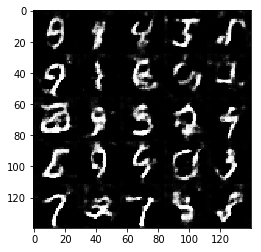

Epoch 1/2... Steps 550... Discriminator Loss: 1.1555... Generator Loss: 1.0521
Epoch 1/2... Steps 600... Discriminator Loss: 1.2457... Generator Loss: 0.8139


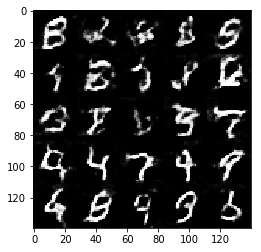

Epoch 1/2... Steps 650... Discriminator Loss: 1.1222... Generator Loss: 1.2163
Epoch 1/2... Steps 700... Discriminator Loss: 1.3456... Generator Loss: 0.5559


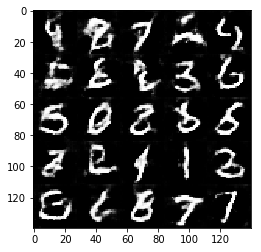

Epoch 1/2... Steps 750... Discriminator Loss: 1.4144... Generator Loss: 1.7038
Epoch 1/2... Steps 800... Discriminator Loss: 1.2620... Generator Loss: 0.9266


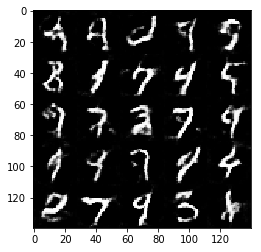

Epoch 1/2... Steps 850... Discriminator Loss: 1.1696... Generator Loss: 1.0211
Epoch 1/2... Steps 900... Discriminator Loss: 1.4598... Generator Loss: 0.4909


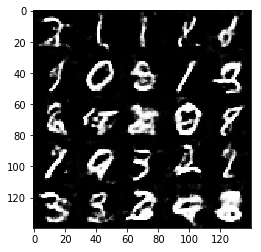

Epoch 2/2... Steps 950... Discriminator Loss: 1.2054... Generator Loss: 1.0955
Epoch 2/2... Steps 1000... Discriminator Loss: 1.1731... Generator Loss: 0.8032


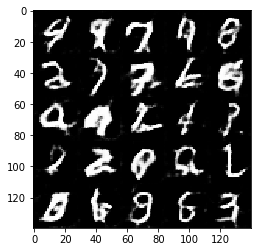

Epoch 2/2... Steps 1050... Discriminator Loss: 1.2024... Generator Loss: 1.0992
Epoch 2/2... Steps 1100... Discriminator Loss: 1.1421... Generator Loss: 1.6779


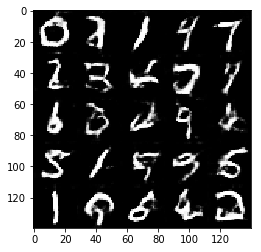

Epoch 2/2... Steps 1150... Discriminator Loss: 1.2626... Generator Loss: 0.5076
Epoch 2/2... Steps 1200... Discriminator Loss: 1.2498... Generator Loss: 1.2527


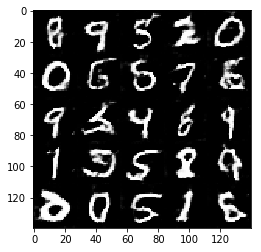

Epoch 2/2... Steps 1250... Discriminator Loss: 1.1263... Generator Loss: 1.2012
Epoch 2/2... Steps 1300... Discriminator Loss: 1.2418... Generator Loss: 0.8094


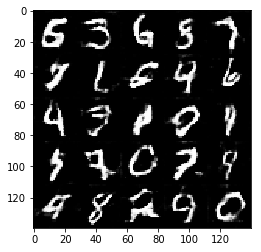

Epoch 2/2... Steps 1350... Discriminator Loss: 1.2476... Generator Loss: 0.7084
Epoch 2/2... Steps 1400... Discriminator Loss: 1.1839... Generator Loss: 1.4182


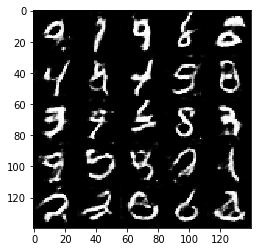

Epoch 2/2... Steps 1450... Discriminator Loss: 1.1816... Generator Loss: 0.9337
Epoch 2/2... Steps 1500... Discriminator Loss: 1.7748... Generator Loss: 0.4632


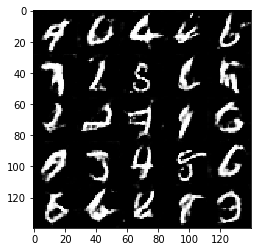

Epoch 2/2... Steps 1550... Discriminator Loss: 1.1395... Generator Loss: 1.3662
Epoch 2/2... Steps 1600... Discriminator Loss: 0.9055... Generator Loss: 1.3817


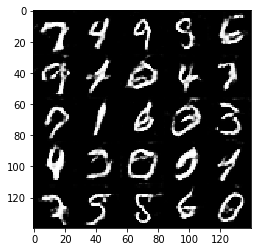

Epoch 2/2... Steps 1650... Discriminator Loss: 1.1027... Generator Loss: 1.7852
Epoch 2/2... Steps 1700... Discriminator Loss: 1.0465... Generator Loss: 1.1438


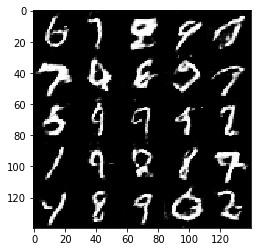

Epoch 2/2... Steps 1750... Discriminator Loss: 1.2349... Generator Loss: 1.3773
Epoch 2/2... Steps 1800... Discriminator Loss: 1.0812... Generator Loss: 1.0421


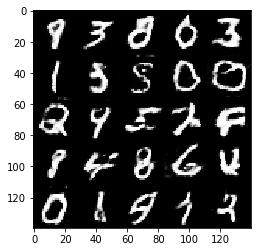

Epoch 2/2... Steps 1850... Discriminator Loss: 1.1008... Generator Loss: 0.7791


In [34]:
# 按照审阅人的意见：
# 对于MNIST这个数据集来说，图像相对较小，只是28 * 28 的黑白色图形，所以Batch size 设置为32或者64都是可以的。
batch_size = 64
z_dim = 128
# 按照审阅人的意见：
# 在GAN中，learning rate 设置为0.0002应该不错，但是有些稍微提高一点能够有效地减少你训练的时间（0.001左右）。
# 经过反复调整，目前觉得0.007的效果比较好
learning_rate = 0.0007
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 50... Discriminator Loss: 1.0838... Generator Loss: 3.0843
Epoch 1/1... Steps 100... Discriminator Loss: 2.5581... Generator Loss: 0.2579


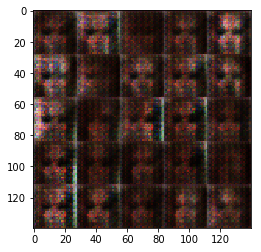

Epoch 1/1... Steps 150... Discriminator Loss: 1.1812... Generator Loss: 0.9308
Epoch 1/1... Steps 200... Discriminator Loss: 1.2485... Generator Loss: 1.1285


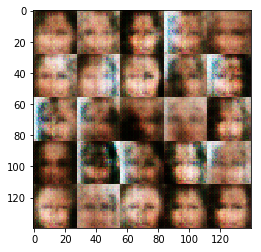

Epoch 1/1... Steps 250... Discriminator Loss: 1.2341... Generator Loss: 1.1977
Epoch 1/1... Steps 300... Discriminator Loss: 1.3443... Generator Loss: 0.7425


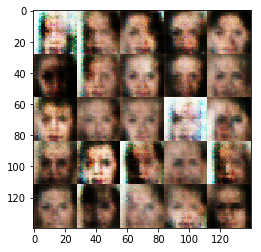

Epoch 1/1... Steps 350... Discriminator Loss: 1.4988... Generator Loss: 0.9859
Epoch 1/1... Steps 400... Discriminator Loss: 1.4959... Generator Loss: 0.6388


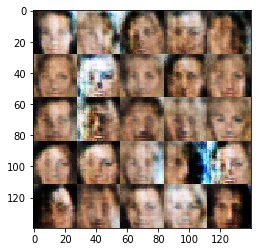

Epoch 1/1... Steps 450... Discriminator Loss: 1.2211... Generator Loss: 0.7146
Epoch 1/1... Steps 500... Discriminator Loss: 1.2882... Generator Loss: 1.0105


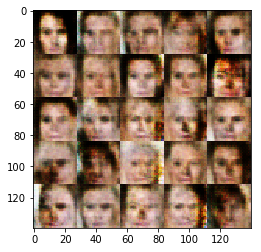

Epoch 1/1... Steps 550... Discriminator Loss: 1.3090... Generator Loss: 1.0298
Epoch 1/1... Steps 600... Discriminator Loss: 1.4186... Generator Loss: 1.0065


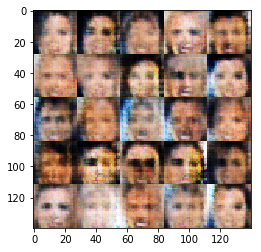

Epoch 1/1... Steps 650... Discriminator Loss: 1.3960... Generator Loss: 0.6803
Epoch 1/1... Steps 700... Discriminator Loss: 1.2241... Generator Loss: 0.9699


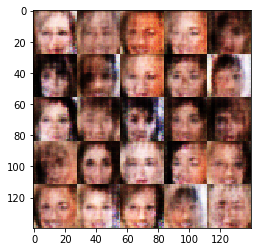

Epoch 1/1... Steps 750... Discriminator Loss: 1.5954... Generator Loss: 1.8570
Epoch 1/1... Steps 800... Discriminator Loss: 1.4170... Generator Loss: 0.7539


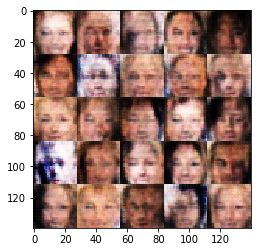

Epoch 1/1... Steps 850... Discriminator Loss: 1.2871... Generator Loss: 0.8861
Epoch 1/1... Steps 900... Discriminator Loss: 1.2445... Generator Loss: 0.8963


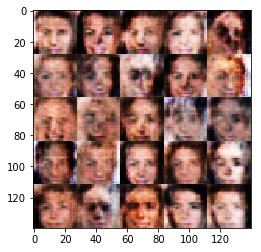

Epoch 1/1... Steps 950... Discriminator Loss: 1.5055... Generator Loss: 1.1974
Epoch 1/1... Steps 1000... Discriminator Loss: 1.4479... Generator Loss: 0.7966


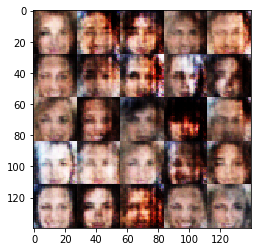

Epoch 1/1... Steps 1050... Discriminator Loss: 1.3128... Generator Loss: 0.7707
Epoch 1/1... Steps 1100... Discriminator Loss: 1.4365... Generator Loss: 0.7266


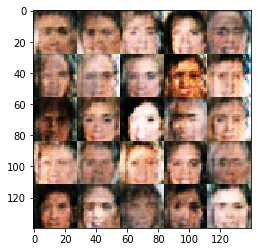

Epoch 1/1... Steps 1150... Discriminator Loss: 1.3333... Generator Loss: 1.2828
Epoch 1/1... Steps 1200... Discriminator Loss: 1.2761... Generator Loss: 0.7743


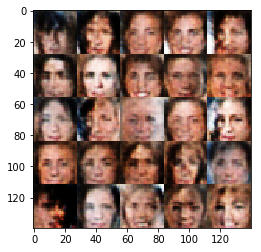

Epoch 1/1... Steps 1250... Discriminator Loss: 1.2187... Generator Loss: 0.8102
Epoch 1/1... Steps 1300... Discriminator Loss: 1.3479... Generator Loss: 0.8449


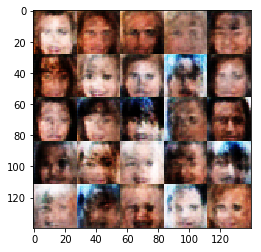

Epoch 1/1... Steps 1350... Discriminator Loss: 1.2891... Generator Loss: 0.9648
Epoch 1/1... Steps 1400... Discriminator Loss: 1.3626... Generator Loss: 0.8679


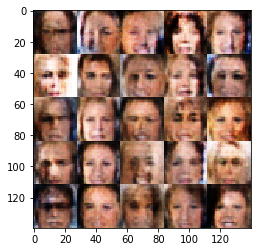

Epoch 1/1... Steps 1450... Discriminator Loss: 1.5032... Generator Loss: 0.7655
Epoch 1/1... Steps 1500... Discriminator Loss: 1.2025... Generator Loss: 1.0065


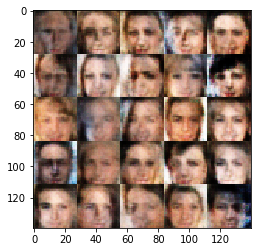

Epoch 1/1... Steps 1550... Discriminator Loss: 1.2389... Generator Loss: 0.7433
Epoch 1/1... Steps 1600... Discriminator Loss: 1.4461... Generator Loss: 0.5043


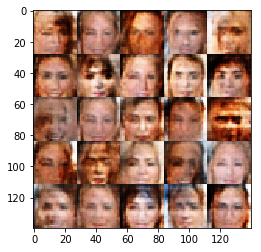

Epoch 1/1... Steps 1650... Discriminator Loss: 1.3138... Generator Loss: 0.8458
Epoch 1/1... Steps 1700... Discriminator Loss: 1.5044... Generator Loss: 0.4831


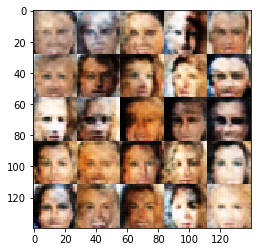

Epoch 1/1... Steps 1750... Discriminator Loss: 1.3594... Generator Loss: 0.6882
Epoch 1/1... Steps 1800... Discriminator Loss: 1.4145... Generator Loss: 0.7450


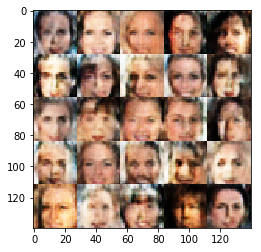

Epoch 1/1... Steps 1850... Discriminator Loss: 1.2501... Generator Loss: 1.0247
Epoch 1/1... Steps 1900... Discriminator Loss: 1.4972... Generator Loss: 0.6187


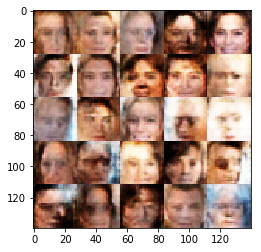

Epoch 1/1... Steps 1950... Discriminator Loss: 1.2269... Generator Loss: 0.8880
Epoch 1/1... Steps 2000... Discriminator Loss: 1.3529... Generator Loss: 0.8923


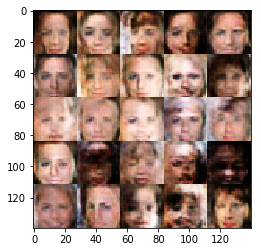

Epoch 1/1... Steps 2050... Discriminator Loss: 1.4086... Generator Loss: 0.6488
Epoch 1/1... Steps 2100... Discriminator Loss: 1.3827... Generator Loss: 0.6448


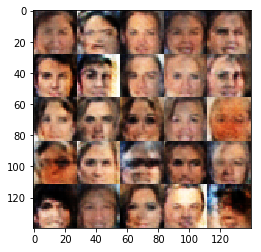

Epoch 1/1... Steps 2150... Discriminator Loss: 1.3336... Generator Loss: 0.7048
Epoch 1/1... Steps 2200... Discriminator Loss: 1.4783... Generator Loss: 0.7172


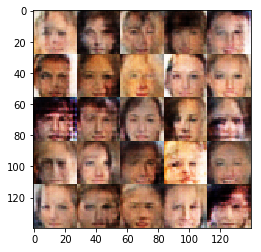

Epoch 1/1... Steps 2250... Discriminator Loss: 1.3269... Generator Loss: 0.8182
Epoch 1/1... Steps 2300... Discriminator Loss: 1.2009... Generator Loss: 1.0248


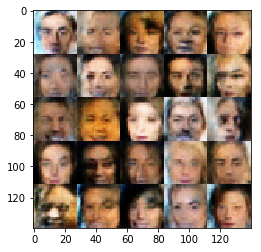

Epoch 1/1... Steps 2350... Discriminator Loss: 1.2061... Generator Loss: 0.8563
Epoch 1/1... Steps 2400... Discriminator Loss: 1.2699... Generator Loss: 0.8012


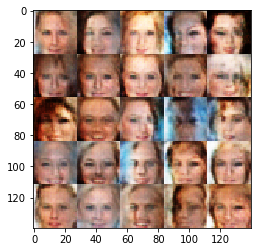

Epoch 1/1... Steps 2450... Discriminator Loss: 1.2388... Generator Loss: 1.0265
Epoch 1/1... Steps 2500... Discriminator Loss: 1.3475... Generator Loss: 1.0213


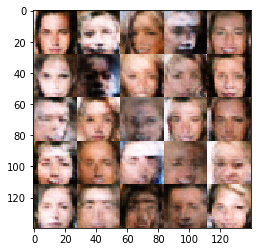

Epoch 1/1... Steps 2550... Discriminator Loss: 1.2110... Generator Loss: 0.9776
Epoch 1/1... Steps 2600... Discriminator Loss: 1.3256... Generator Loss: 0.9668


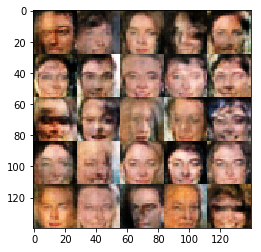

Epoch 1/1... Steps 2650... Discriminator Loss: 1.3782... Generator Loss: 0.5890
Epoch 1/1... Steps 2700... Discriminator Loss: 1.2902... Generator Loss: 0.8102


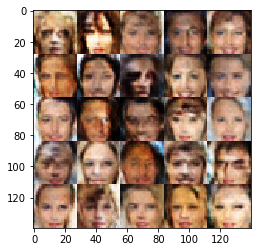

Epoch 1/1... Steps 2750... Discriminator Loss: 1.2773... Generator Loss: 0.8770
Epoch 1/1... Steps 2800... Discriminator Loss: 1.4556... Generator Loss: 0.8188


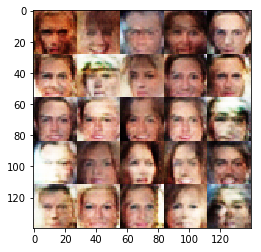

Epoch 1/1... Steps 2850... Discriminator Loss: 1.3012... Generator Loss: 0.7025
Epoch 1/1... Steps 2900... Discriminator Loss: 1.3269... Generator Loss: 0.6818


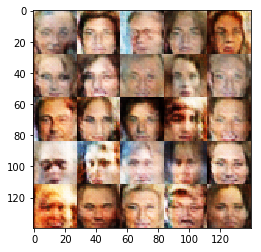

Epoch 1/1... Steps 2950... Discriminator Loss: 1.3185... Generator Loss: 0.7823
Epoch 1/1... Steps 3000... Discriminator Loss: 1.4013... Generator Loss: 0.7623


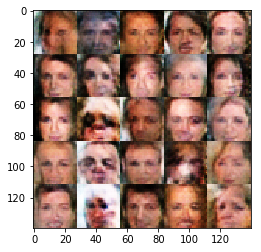

Epoch 1/1... Steps 3050... Discriminator Loss: 1.2999... Generator Loss: 0.7242
Epoch 1/1... Steps 3100... Discriminator Loss: 1.4324... Generator Loss: 0.5702


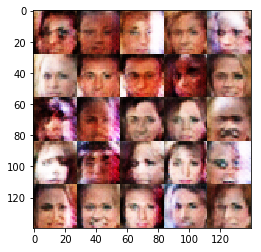

Epoch 1/1... Steps 3150... Discriminator Loss: 1.4244... Generator Loss: 0.7117
Epoch 1/1... Steps 3200... Discriminator Loss: 1.3670... Generator Loss: 0.6880


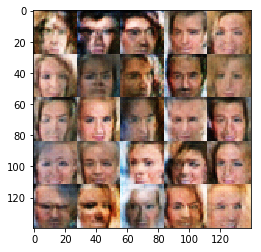

Epoch 1/1... Steps 3250... Discriminator Loss: 1.3022... Generator Loss: 0.9000
Epoch 1/1... Steps 3300... Discriminator Loss: 1.3378... Generator Loss: 0.7979


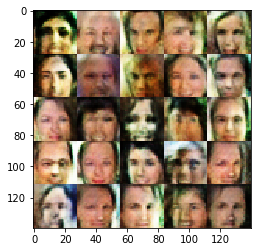

Epoch 1/1... Steps 3350... Discriminator Loss: 1.3994... Generator Loss: 0.6833
Epoch 1/1... Steps 3400... Discriminator Loss: 1.2664... Generator Loss: 0.9019


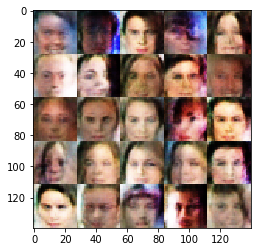

Epoch 1/1... Steps 3450... Discriminator Loss: 1.2752... Generator Loss: 0.8057
Epoch 1/1... Steps 3500... Discriminator Loss: 1.2315... Generator Loss: 1.0064


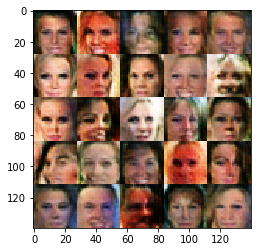

Epoch 1/1... Steps 3550... Discriminator Loss: 1.3253... Generator Loss: 0.7414
Epoch 1/1... Steps 3600... Discriminator Loss: 1.3195... Generator Loss: 0.7928


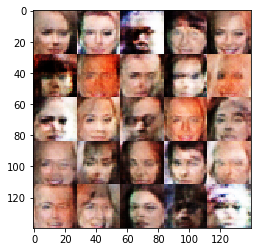

Epoch 1/1... Steps 3650... Discriminator Loss: 1.3469... Generator Loss: 0.9296
Epoch 1/1... Steps 3700... Discriminator Loss: 1.2966... Generator Loss: 0.8826


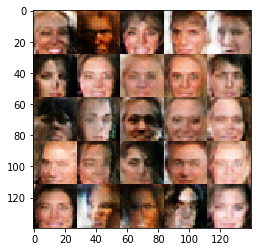

Epoch 1/1... Steps 3750... Discriminator Loss: 1.1071... Generator Loss: 0.9700
Epoch 1/1... Steps 3800... Discriminator Loss: 1.3512... Generator Loss: 0.7221


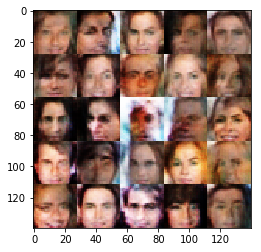

Epoch 1/1... Steps 3850... Discriminator Loss: 1.3277... Generator Loss: 0.6828
Epoch 1/1... Steps 3900... Discriminator Loss: 1.1556... Generator Loss: 1.0023


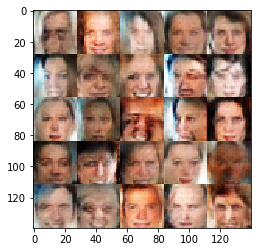

Epoch 1/1... Steps 3950... Discriminator Loss: 1.2976... Generator Loss: 0.8482
Epoch 1/1... Steps 4000... Discriminator Loss: 1.3250... Generator Loss: 0.6873


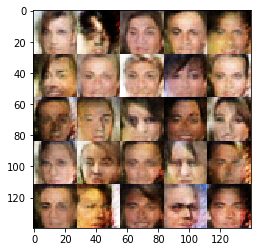

Epoch 1/1... Steps 4050... Discriminator Loss: 1.3077... Generator Loss: 0.6971
Epoch 1/1... Steps 4100... Discriminator Loss: 1.1707... Generator Loss: 1.2075


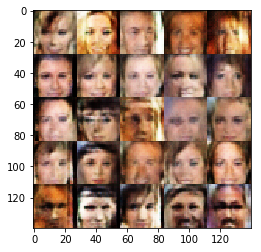

Epoch 1/1... Steps 4150... Discriminator Loss: 1.3291... Generator Loss: 0.8469
Epoch 1/1... Steps 4200... Discriminator Loss: 1.4575... Generator Loss: 0.8063


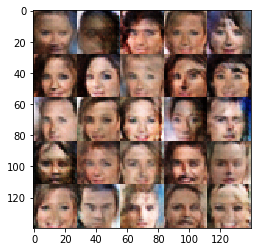

Epoch 1/1... Steps 4250... Discriminator Loss: 1.3788... Generator Loss: 1.1498
Epoch 1/1... Steps 4300... Discriminator Loss: 1.3807... Generator Loss: 0.9663


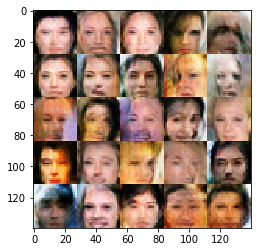

Epoch 1/1... Steps 4350... Discriminator Loss: 1.4009... Generator Loss: 0.8133
Epoch 1/1... Steps 4400... Discriminator Loss: 1.4279... Generator Loss: 0.6830


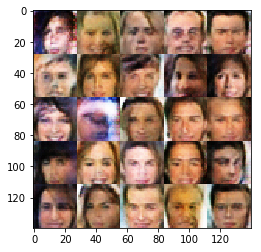

Epoch 1/1... Steps 4450... Discriminator Loss: 1.4650... Generator Loss: 0.7089
Epoch 1/1... Steps 4500... Discriminator Loss: 1.3581... Generator Loss: 0.7011


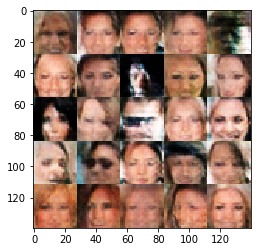

Epoch 1/1... Steps 4550... Discriminator Loss: 1.3190... Generator Loss: 0.9502
Epoch 1/1... Steps 4600... Discriminator Loss: 1.2027... Generator Loss: 0.8087


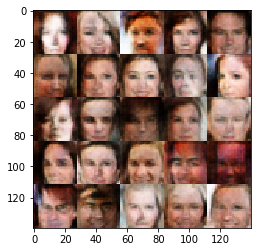

Epoch 1/1... Steps 4650... Discriminator Loss: 1.3053... Generator Loss: 1.0460
Epoch 1/1... Steps 4700... Discriminator Loss: 1.4228... Generator Loss: 0.7045


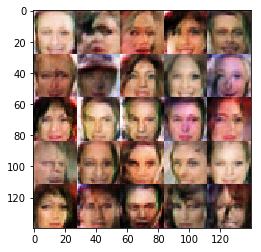

Epoch 1/1... Steps 4750... Discriminator Loss: 1.2975... Generator Loss: 0.7880
Epoch 1/1... Steps 4800... Discriminator Loss: 1.3800... Generator Loss: 0.7092


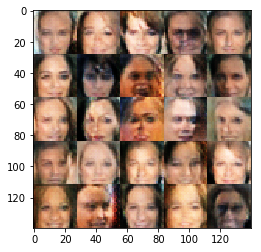

Epoch 1/1... Steps 4850... Discriminator Loss: 1.3050... Generator Loss: 0.8143
Epoch 1/1... Steps 4900... Discriminator Loss: 1.4672... Generator Loss: 0.5984


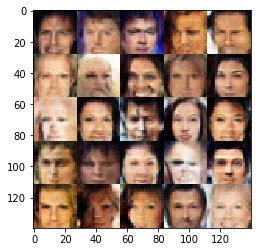

Epoch 1/1... Steps 4950... Discriminator Loss: 1.3488... Generator Loss: 0.9606
Epoch 1/1... Steps 5000... Discriminator Loss: 1.3980... Generator Loss: 0.8276


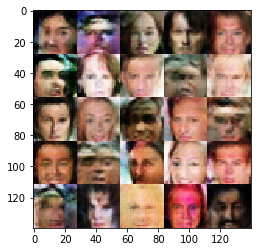

Epoch 1/1... Steps 5050... Discriminator Loss: 1.2838... Generator Loss: 0.9512
Epoch 1/1... Steps 5100... Discriminator Loss: 1.3965... Generator Loss: 0.7459


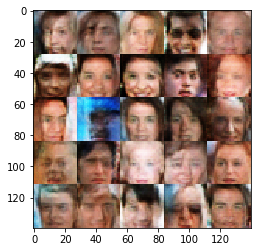

Epoch 1/1... Steps 5150... Discriminator Loss: 1.3948... Generator Loss: 0.7434
Epoch 1/1... Steps 5200... Discriminator Loss: 1.3606... Generator Loss: 0.8072


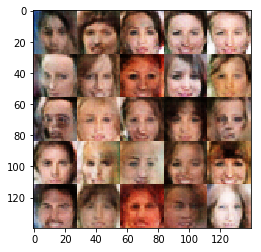

Epoch 1/1... Steps 5250... Discriminator Loss: 1.5123... Generator Loss: 0.5848
Epoch 1/1... Steps 5300... Discriminator Loss: 1.3777... Generator Loss: 0.8208


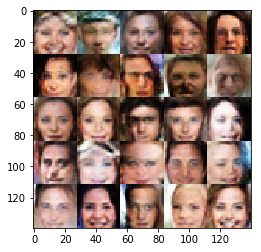

Epoch 1/1... Steps 5350... Discriminator Loss: 1.1531... Generator Loss: 1.0388
Epoch 1/1... Steps 5400... Discriminator Loss: 1.4034... Generator Loss: 0.7573


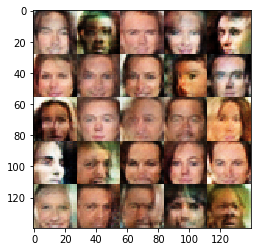

Epoch 1/1... Steps 5450... Discriminator Loss: 1.4383... Generator Loss: 0.6936
Epoch 1/1... Steps 5500... Discriminator Loss: 1.4117... Generator Loss: 0.8373


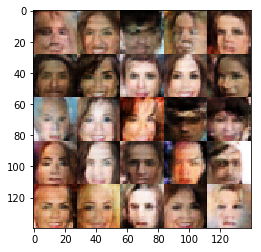

Epoch 1/1... Steps 5550... Discriminator Loss: 1.3019... Generator Loss: 0.8411
Epoch 1/1... Steps 5600... Discriminator Loss: 1.2948... Generator Loss: 0.7489


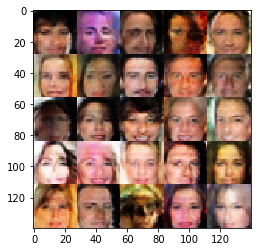

Epoch 1/1... Steps 5650... Discriminator Loss: 1.2259... Generator Loss: 0.8363
Epoch 1/1... Steps 5700... Discriminator Loss: 1.4151... Generator Loss: 0.6119


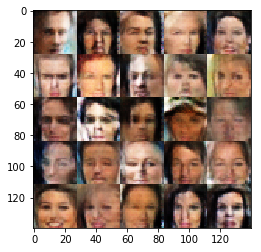

Epoch 1/1... Steps 5750... Discriminator Loss: 1.3604... Generator Loss: 0.6727
Epoch 1/1... Steps 5800... Discriminator Loss: 1.3182... Generator Loss: 0.9196


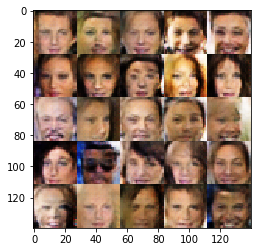

Epoch 1/1... Steps 5850... Discriminator Loss: 1.3647... Generator Loss: 0.7228
Epoch 1/1... Steps 5900... Discriminator Loss: 1.3529... Generator Loss: 0.8177


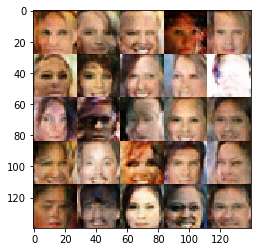

Epoch 1/1... Steps 5950... Discriminator Loss: 1.2046... Generator Loss: 0.9981
Epoch 1/1... Steps 6000... Discriminator Loss: 1.3749... Generator Loss: 0.8253


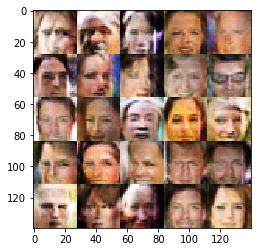

Epoch 1/1... Steps 6050... Discriminator Loss: 1.3155... Generator Loss: 0.8071
Epoch 1/1... Steps 6100... Discriminator Loss: 1.2704... Generator Loss: 1.1085


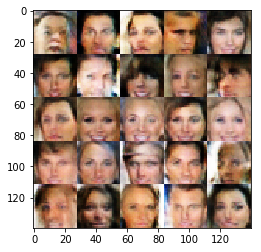

Epoch 1/1... Steps 6150... Discriminator Loss: 1.3579... Generator Loss: 0.6102
Epoch 1/1... Steps 6200... Discriminator Loss: 1.3206... Generator Loss: 0.7469


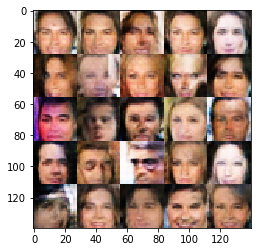

Epoch 1/1... Steps 6250... Discriminator Loss: 1.1675... Generator Loss: 0.9918
Epoch 1/1... Steps 6300... Discriminator Loss: 1.2380... Generator Loss: 0.7565


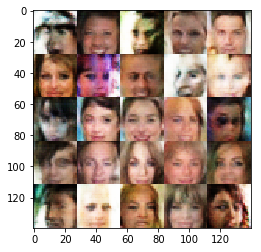

In [38]:
# 按照审阅人的意见：
# 对于celeA这个数据集来说，由于它包含了许多大图像，所以Batch size设置为16或者32比较合适。
batch_size = 32
z_dim = 128
learning_rate = 0.0009
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.